## librerías necesarias
* Vamos a usar keras para realizar los modelos de Deep Learning
* Usaremos como modelo preentrenado InceptionV3

In [1]:
import keras
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.layers import *
from keras.models import *
from keras.applications import *
from keras.optimizers import *
from keras.regularizers import *
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau
import keras.backend as K
from keras.preprocessing import image

import matplotlib.pyplot as plt
from skimage.io import imread

import pandas as pd
import json
from sklearn.preprocessing import MultiLabelBinarizer
import gc
import time

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import scikitplot as skplt

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

* Definiendo el tamaño de Batch (bloque de datos para entrenar el modelo)
* El tamaño de la imagen que se usa para entrenar el modelo de inceptionV3 es de tamaño 299 * 299 * 3

In [2]:
BATCH_SIZE = 16
TARGET_SIZE = (299, 299)

## Tratamiento de imágenes

* Vamos a usar la clase ImageDataGenerator de Keras para poder leer los datos de disco y procesarlos en la GPU
* Esto se realiza porque se necesita mucha memoria para tener todos los datos en memoria, por lo que es mejor leerlos de disco cuando sea necesario
* Tiene la desventaja de que el entrenamiento tarda, pero la ventaja es que puede trabajar con grandes conjuntos de datos
* Para aumentar el número de ejemplos, vamos a usar data augmentation.
* Usamos como procesamiento de datos la definida en InceptionV3.

In [3]:
datagen = ImageDataGenerator(width_shift_range=0.4,
                             height_shift_range=0.4,
                             shear_range=0.4,
                             zoom_range=0.4,
                             horizontal_flip=True,
                             vertical_flip=False,
                             preprocessing_function=preprocess_input)

* Vamos a generar tanto para los datos de entrenamiento como los datos de validación
* Como tenemos pocas imágenes para el conjunto de validación, también vamos a usar data augmentation

In [4]:
train_generator = datagen.flow_from_directory(
    '../input/chest-xray-pneumonia/chest_xray/chest_xray/train',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True)

Found 5216 images belonging to 2 classes.


In [5]:
val_generator = datagen.flow_from_directory(
    '../input/chest-xray-pneumonia/chest_xray/chest_xray/val',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True)

Found 16 images belonging to 2 classes.


## Analizando las imágenes

In [6]:
train_imagen = ImageDataGenerator().flow_from_directory('../input/chest-xray-pneumonia/chest_xray/chest_xray/train', batch_size=16, class_mode='categorical')

Found 5216 images belonging to 2 classes.


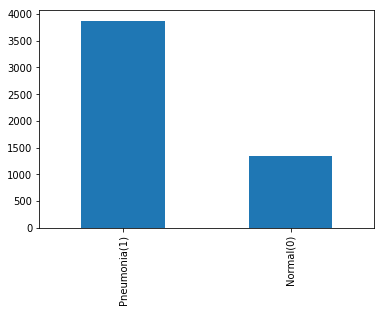

In [7]:
pd.Series(train_imagen.classes).apply(lambda x: 'Normal(0)' if x == 0 else 'Pneumonia(1)').value_counts().plot.bar()

In [8]:
# Get few samples for both the classes
images_, classes_ = next(train_imagen)
pneumonia_samples = [images_[enum] for enum, class_ in enumerate(classes_) if class_[1] == 1]
normal_samples = [images_[enum] for enum, class_ in enumerate(classes_) if class_[0] == 1]

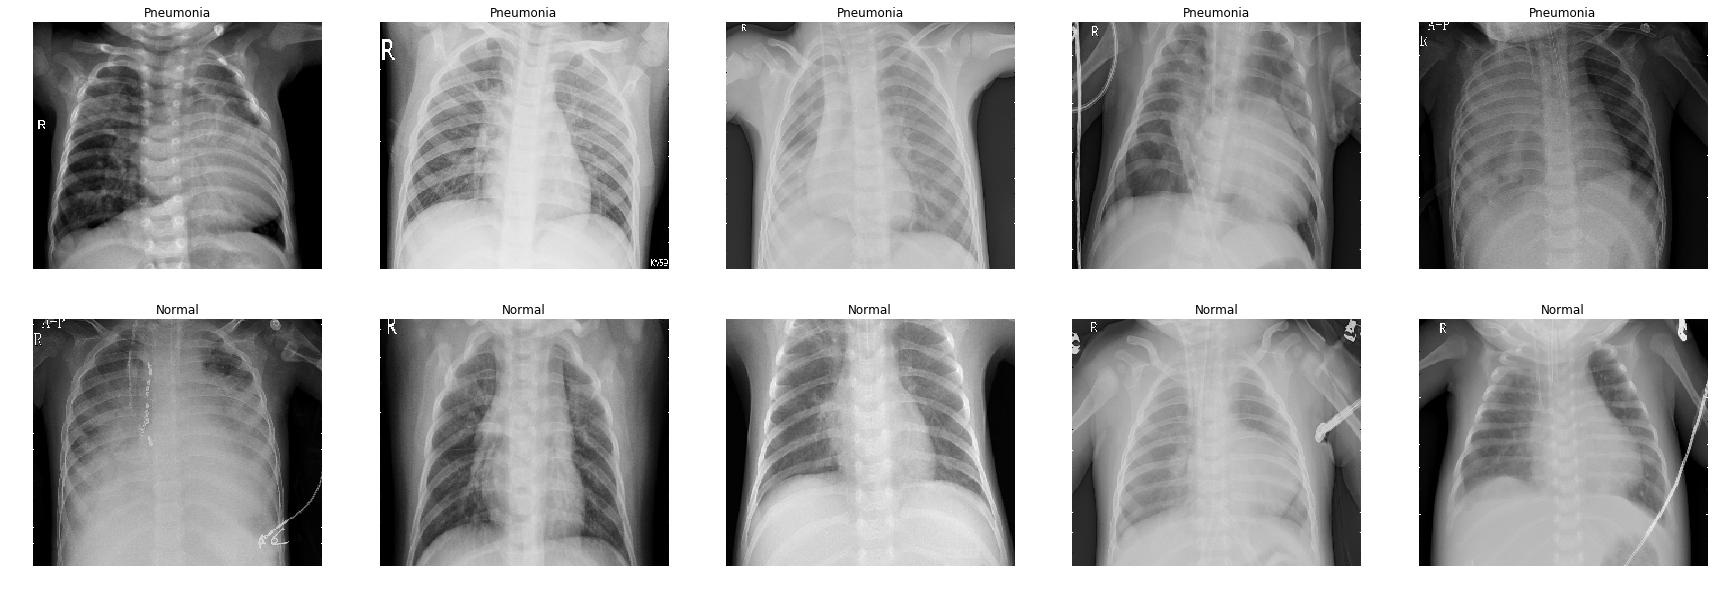

In [9]:
# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
#     img = imread(samples[i])
    ax[i//5, i%5].imshow(image.array_to_img(samples[i]))
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

## Entrenando el modelo
* Vamos a definir un modelo basado en InceptionV3
* Empezaremos congelando todas las capas menos la última. La última capa será de tamaño 2, que coincide con el número de clases

In [10]:
basic_model = InceptionV3(include_top=False, weights='imagenet', pooling='avg')

# Congelando todas las capas
for layer in basic_model.layers:
    layer.trainable = False

input_tensor = basic_model.input

x = basic_model.output
x = BatchNormalization()(x)
x = Dropout(.5)(x)
# Agregando una última capa de tamaño 2
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_tensor, outputs=x)
model.compile(optimizer=Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

87916544/87910968 [==============================] - 6s 0us/step


* Entrenando el modelo

In [11]:
model.fit_generator(train_generator,
                    epochs=5,
                    steps_per_epoch=train_generator.n / (BATCH_SIZE))

Epoch 1/5
326/326 [==============================] - 148s 454ms/step - loss: 0.3767 - acc: 0.8413
Epoch 2/5
326/326 [==============================] - 141s 434ms/step - loss: 0.2848 - acc: 0.8873
Epoch 3/5
326/326 [==============================] - 140s 430ms/step - loss: 0.2780 - acc: 0.8890
Epoch 4/5
326/326 [==============================] - 141s 432ms/step - loss: 0.2635 - acc: 0.8934
Epoch 5/5
326/326 [==============================] - 140s 430ms/step - loss: 0.2588 - acc: 0.8924


* El siguiente paso es descongelar las capas y volver a entrenar el modelo
* Se agregar una pequeña regularización al modelo y el ratio de aprendizaje se reduce
* En este caso se evalua el modelo con el conjunto de validación


In [12]:
# Descongelando las capas y agregando regularización
for layer in model.layers:
    layer.W_regularizer = l2(1e-3)
    layer.trainable = True

In [13]:
model = Model(inputs=input_tensor, outputs=x)
model.compile(optimizer=Adam(lr=1e-4, decay=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

* Vamos a agregar un checkpoint para guardar el mejor modelo
* También vamos a agregar una parada

In [14]:
checkpointer = ModelCheckpoint(filepath='modelInception.hdf5', verbose=1, save_best_only=True)
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=2, mode='auto', min_delta=1e-4)

* Entrenando el modelo con el conjunto de entrenamiento y validando con el conjunto de validación

In [15]:
model.fit_generator(train_generator,
                    epochs=200,
                    validation_data=val_generator,
                    steps_per_epoch=train_generator.n / BATCH_SIZE,
                    validation_steps=val_generator.n / BATCH_SIZE,
                    callbacks=[checkpointer, earlyStopping],
                    verbose=1,
                    initial_epoch=5,
                    shuffle=True)

Epoch 6/200
326/326 [==============================] - 182s 558ms/step - loss: 0.2590 - acc: 0.9089 - val_loss: 0.8709 - val_acc: 0.7500

Epoch 00006: val_loss improved from inf to 0.87090, saving model to modelInception.hdf5
Epoch 7/200
326/326 [==============================] - 155s 476ms/step - loss: 0.1547 - acc: 0.9442 - val_loss: 0.3597 - val_acc: 0.8125

Epoch 00007: val_loss improved from 0.87090 to 0.35969, saving model to modelInception.hdf5
Epoch 8/200
326/326 [==============================] - 158s 486ms/step - loss: 0.1167 - acc: 0.9571 - val_loss: 0.0405 - val_acc: 1.0000

Epoch 00008: val_loss improved from 0.35969 to 0.04052, saving model to modelInception.hdf5
Epoch 9/200
326/326 [==============================] - 159s 488ms/step - loss: 0.1038 - acc: 0.9634 - val_loss: 0.3436 - val_acc: 0.8750

Epoch 00009: val_loss did not improve from 0.04052
Epoch 10/200
326/326 [==============================] - 158s 486ms/step - loss: 0.0958 - acc: 0.9655 - val_loss: 0.0130 - val

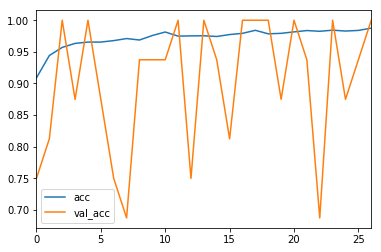

In [16]:
# Comportamiento de la precisión
pd.DataFrame(model.history.history)[['acc', 'val_acc']].plot()

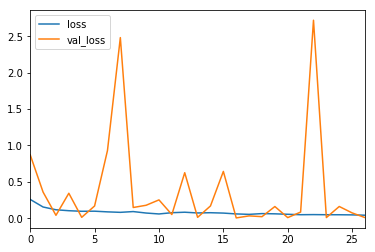

In [17]:
# Comportamiento de la función de pérdida
pd.DataFrame(model.history.history)[['loss', 'val_loss']].plot()

## Probando el modelo en el conjunto de Test

### Leyendo el mejor modelo

In [18]:
best_model = load_model('modelInception.hdf5')

### Generando las imágenes para el conjunto de test

In [19]:
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    '../input/chest-xray-pneumonia/chest_xray/chest_xray/test',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False)

Found 624 images belonging to 2 classes.


### Prediciendo y evaluando en test

In [20]:
pred_test = best_model.predict_generator(test_generator, steps=test_generator.n / BATCH_SIZE, verbose=1)
class_test = test_generator.classes
class_predict = (pred_test > 0.5).astype(int).reshape((len(pred_test), 1))

39/39 [==============================] - 10s 249ms/step


In [21]:
# Accuracy
print('Accuracy: ' + str(accuracy_score(class_test, class_predict)))
# AUC
print('AUC: ' + str(roc_auc_score(class_test, pred_test)))

Accuracy: 0.9150641025641025
AUC: 0.97548761779531


#### Matriz de confusión

<Figure size 432x288 with 0 Axes>

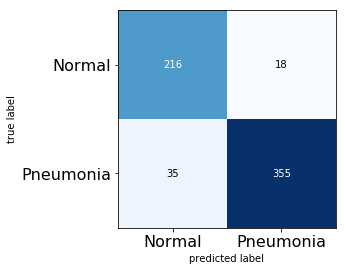

In [22]:
cm  = confusion_matrix(class_test, class_predict)
plt.figure()
plot_confusion_matrix(cm,figsize=(4,4), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

#### Curva ROC

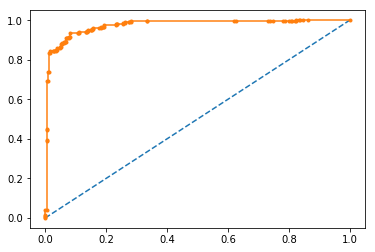

In [23]:
fpr, tpr, thresholds = roc_curve(class_test, pred_test)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

## LIME para entender al modelo
* Vamos a analizar casos donde el modelo ha predicho correctamente como incorrectamente

In [24]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
explainer = lime_image.LimeImageExplainer()

In [25]:
def predict_image(image):
    img_array = image
    if len(img_array.shape) >= 4:
        return best_model.predict(img_array)
    img_array = img_array.reshape(1, img_array.shape[0], img_array.shape[1], img_array.shape[2])
    return best_model.predict(img_array)

In [26]:
explanation = explainer.explain_instance(next(test_generator)[0][0], predict_image)

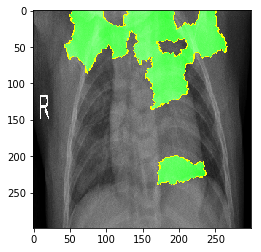

In [27]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))